In [1]:
import pandas as pd
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.exceptions import ConvergenceWarning
from tqdm import tqdm, tqdm_notebook

# Preprocessing

### Import Dataset

In [2]:
df = pd.read_csv(
    "../Datasets/Raw_Data/GSE221521_gene_expression.csv", index_col=1)
df.head()

gene_id  \
gene_name                     
AC073488.4  ENSG00000282222   
AC119427.1  ENSG00000282221   
MIR543      ENSG00000212040   
MADD        ENSG00000110514   
AL356737.2  ENSG00000287159   

                                                  description  \
gene_name                                                       
AC073488.4  chromodomain protein, Y chromosome-like (CDYL)...   
AC119427.1                novel transcript, antisense to LAD1   
MIR543       microRNA 543 [Source:HGNC Symbol;Acc:HGNC:33664]   
MADD        MAP kinase activating death domain [Source:HGN...   
AL356737.2                novel transcript, antisense to GPC5   

                       gene_type                   locus  RNA1_FPKM  \
gene_name                                                             
AC073488.4  processed_pseudogene       X:9410789-9411545   0.000000   
AC119427.1                lncRNA   1:201399633-201401190   0.000000   
MIR543                     miRNA  14:101031987-101032064   0.000000   
MADD              protein_coding    11:47269161-47330031   6.345943   
AL356737.2                lncRNA    13:92610646-92677725   0.000000   

            RNA102_FPKM  RNA104_FPKM  RNA108_FPKM  RNA109_FPKM  RNA110_FPKM  \
gene_name                                                                     
AC073488.4     0.000000     0.000000     0.000000     0.000000     0.000000   
AC119427.1     0.000000     0.000000     0.000000     0.000000     0.000000   
MIR543         0.000000     0.000000     0.000000     0.000000     0.962816   
MADD           8.482109    10.209322     7.143557     5.671481     7.776351   
AL356737.2     0.000000     0.000000     0.000000     0.000000     0.000000   

            ...  R_JS032_count  R_JS033_count  R_JS034_count  R_JS035_count  \
gene_name   ...                                                               
AC073488.4  ...              0              0              0              0   
AC119427.1  ...              0              0              0              0   
MIR543      ...              0              0              0              0   
MADD        ...           1187           1254           1767           1184   
AL356737.2  ...              0              0              0              0   

            R_JS036_count  R_JS037_count  R_JS038_count  R_JS039_count  \
gene_name                                                                
AC073488.4              0              0              1              0   
AC119427.1              0              0              0              0   
MIR543                  0              0              0              0   
MADD                 2418           1294           1254           1461   
AL356737.2              0              0              0              0   

            R_JS040_count  R_JS041_count  
gene_name                                 
AC073488.4              0              0  
AC119427.1              0              0  
MIR543                  0              0  
MADD                 1323           1795  
AL356737.2              0              0  

[5 rows x 390 columns]

### Check Gene Types

In [3]:
df['gene_type'].value_counts()

protein_coding                        19973
lncRNA                                16889
processed_pseudogene                  10162
unprocessed_pseudogene                 2612
misc_RNA                               2220
snRNA                                  1910
miRNA                                  1879
TEC                                    1057
snoRNA                                  943
transcribed_unprocessed_pseudogene      938
transcribed_processed_pseudogene        500
rRNA_pseudogene                         496
IG_V_pseudogene                         187
IG_V_gene                               145
transcribed_unitary_pseudogene          138
TR_V_gene                               106
unitary_pseudogene                       98
TR_J_gene                                79
rRNA                                     53
scaRNA                                   49
polymorphic_pseudogene                   48
IG_D_gene                                37
TR_V_pseudogene                 

### Transform the Dataset

In [4]:
df = df[df['gene_type'] == 'transcribed_unprocessed_pseudogene']
df = df.drop(['gene_type', 'description', 'gene_id', 'locus'], axis=1)
df = df.iloc[:, :193]
df = df.T
df.to_csv('../Datasets/Dataset14/data0.csv')

### Combine with Diagnosis

In [5]:
df = pd.read_csv('../Datasets/Dataset14/data0.csv', index_col=0)
diagnosis = pd.read_csv("../Datasets/Dataset05/Diagnosis.csv", index_col=0)
df['Diagnosis'] = diagnosis['Diagnosis']
df.to_csv('../Datasets/Dataset14/data1.csv')

df.head()

OR52K3P    BMS1P2  AL355075.5  NBEAP1    DTX2P1  AC245297.1  \
RNA1_FPKM    10.035735  0.341100    0.000000     0.0  1.702632    0.000000   
RNA102_FPKM  10.127568  0.808948    0.000000     0.0  4.984110    0.249101   
RNA104_FPKM   8.540649  0.031792    0.119041     0.0  1.949264    0.244706   
RNA108_FPKM  16.999575  0.000000    0.193920     0.0  3.003744    0.265804   
RNA109_FPKM  15.564663  0.377657    0.257096     0.0  3.035908    0.198273   

              ABCC6P2  PPBPP2  AC142381.3    TXLNGY  ...    PKD1P4  VWFP1  \
RNA1_FPKM    0.000000     0.0         0.0  0.000000  ...  6.584021    0.0   
RNA102_FPKM  0.000000     0.0         0.0  0.000000  ...  7.154961    0.0   
RNA104_FPKM  0.000000     0.0         0.0  0.000000  ...  8.823690    0.0   
RNA108_FPKM  0.000000     0.0         0.0  4.000012  ...  6.893874    0.0   
RNA109_FPKM  0.061726     0.0         0.0  3.143782  ...  7.685082    0.0   

                ESPNP  AC011487.2  AC009093.8  AC090616.1  CES5AP1  DDX11L10  \
RNA1_FPKM    0.000000         0.0    1.652895         0.0      0.0  0.250156   
RNA102_FPKM  0.000000         0.0    1.372022         0.0      0.0  2.610357   
RNA104_FPKM  0.014109         0.0    1.732721         0.0      0.0  0.366315   
RNA108_FPKM  0.000000         0.0    1.463873         0.0      0.0  3.834270   
RNA109_FPKM  0.045715         0.0    1.351726         0.0      0.0  0.863303   

             GOLGA2P5  Diagnosis  
RNA1_FPKM    0.496067          1  
RNA102_FPKM  0.786663          2  
RNA104_FPKM  0.514003          1  
RNA108_FPKM  0.562079          1  
RNA109_FPKM  0.573845          0  

[5 rows x 939 columns]

### Remove Patients who hasn't Diabetic

In [6]:
df = pd.read_csv('../Datasets/Dataset14/data1.csv', index_col=0)
df = df[df['Diagnosis'] != 0]
df['Diagnosis'] = df['Diagnosis'] - 1
df.to_csv("../Datasets/Dataset14/data2.csv")
df.head()

OR52K3P    BMS1P2  AL355075.5  NBEAP1    DTX2P1  AC245297.1  \
RNA1_FPKM    10.035735  0.341100    0.000000     0.0  1.702632    0.000000   
RNA102_FPKM  10.127568  0.808948    0.000000     0.0  4.984110    0.249101   
RNA104_FPKM   8.540649  0.031792    0.119041     0.0  1.949264    0.244706   
RNA108_FPKM  16.999575  0.000000    0.193920     0.0  3.003744    0.265804   
RNA110_FPKM   5.640337  0.000000    0.120739     0.0  2.621902    0.434573   

             ABCC6P2    PPBPP2  AC142381.3    TXLNGY  ...    PKD1P4  VWFP1  \
RNA1_FPKM        0.0  0.000000         0.0  0.000000  ...  6.584021    0.0   
RNA102_FPKM      0.0  0.000000         0.0  0.000000  ...  7.154961    0.0   
RNA104_FPKM      0.0  0.000000         0.0  0.000000  ...  8.823690    0.0   
RNA108_FPKM      0.0  0.000000         0.0  4.000012  ...  6.893874    0.0   
RNA110_FPKM      0.0  0.043969         0.0  0.693268  ...  2.240804    0.0   

                ESPNP  AC011487.2  AC009093.8  AC090616.1  CES5AP1  DDX11L10  \
RNA1_FPKM    0.000000         0.0    1.652895         0.0      0.0  0.250156   
RNA102_FPKM  0.000000         0.0    1.372022         0.0      0.0  2.610357   
RNA104_FPKM  0.014109         0.0    1.732721         0.0      0.0  0.366315   
RNA108_FPKM  0.000000         0.0    1.463873         0.0      0.0  3.834270   
RNA110_FPKM  0.100197         0.0    2.246597         0.0      0.0  5.811936   

             GOLGA2P5  Diagnosis  
RNA1_FPKM    0.496067          0  
RNA102_FPKM  0.786663          1  
RNA104_FPKM  0.514003          0  
RNA108_FPKM  0.562079          0  
RNA110_FPKM  0.455057          0  

[5 rows x 939 columns]

### Analyze the Dataset

In [7]:
df = pd.read_csv("../Datasets/Dataset14/data2.csv", index_col=0)
df.describe()

OR52K3P      BMS1P2  AL355075.5      NBEAP1      DTX2P1  AC245297.1  \
count  143.000000  143.000000  143.000000  143.000000  143.000000  143.000000   
mean     8.316586    0.239817    0.268955    0.004472    3.047470    0.371261   
std      4.644597    0.284381    0.236818    0.013828    1.190552    0.240745   
min      1.244909    0.000000    0.000000    0.000000    0.142581    0.000000   
25%      4.997580    0.000000    0.065037    0.000000    2.250173    0.205608   
50%      7.869597    0.129219    0.215923    0.000000    2.934879    0.329382   
75%     10.650475    0.352282    0.445466    0.000000    3.895436    0.474689   
max     30.853371    1.398421    1.022097    0.086504    6.141386    1.076689   

          ABCC6P2      PPBPP2  AC142381.3      TXLNGY  ...      PKD1P4  \
count  143.000000  143.000000  143.000000  143.000000  ...  143.000000   
mean     0.051101    0.004819    0.000801    1.758671  ...    7.336843   
std      0.066649    0.020753    0.006015    1.925157  ...    3.677166   
min      0.000000    0.000000    0.000000    0.000000  ...    0.308838   
25%      0.000000    0.000000    0.000000    0.000000  ...    4.636613   
50%      0.000000    0.000000    0.000000    1.538040  ...    7.154961   
75%      0.076286    0.000000    0.000000    3.073348  ...    9.773809   
max      0.300449    0.194735    0.062014    8.823226  ...   19.189810   

            VWFP1       ESPNP  AC011487.2  AC009093.8  AC090616.1     CES5AP1  \
count  143.000000  143.000000  143.000000  143.000000       143.0  143.000000   
mean     0.004701    0.045834    0.002875    1.805737         0.0    0.001842   
std      0.017646    0.054879    0.011853    0.915221         0.0    0.009108   
min      0.000000    0.000000    0.000000    0.213953         0.0    0.000000   
25%      0.000000    0.000000    0.000000    1.137881         0.0    0.000000   
50%      0.000000    0.030917    0.000000    1.655268         0.0    0.000000   
75%      0.000000    0.062649    0.000000    2.246074         0.0    0.000000   
max      0.124005    0.317138    0.070649    5.717096         0.0    0.067884   

         DDX11L10    GOLGA2P5   Diagnosis  
count  143.000000  143.000000  143.000000  
mean     4.760307    0.541851    0.468531  
std      5.305589    0.222528    0.500763  
min      0.000000    0.104870    0.000000  
25%      0.522674    0.403312    0.000000  
50%      2.951263    0.498889    0.000000  
75%      7.039596    0.669898    1.000000  
max     24.108405    1.221731    1.000000  

[8 rows x 939 columns]

In [8]:
df.dtypes

OR52K3P       float64
BMS1P2        float64
AL355075.5    float64
NBEAP1        float64
DTX2P1        float64
               ...   
AC090616.1    float64
CES5AP1       float64
DDX11L10      float64
GOLGA2P5      float64
Diagnosis       int64
Length: 939, dtype: object

In [9]:
df.isnull().sum()

OR52K3P       0
BMS1P2        0
AL355075.5    0
NBEAP1        0
DTX2P1        0
             ..
AC090616.1    0
CES5AP1       0
DDX11L10      0
GOLGA2P5      0
Diagnosis     0
Length: 939, dtype: int64

# Feature Selection

### Select best Feature Selection Algorithm

In [10]:
df = pd.read_csv("../Datasets/Dataset14/data2.csv", index_col=0)

features = df.drop('Diagnosis', axis=1)
target = df['Diagnosis']

result_df = pd.DataFrame(
    columns=['Feature Selection Algorithm', 'Feature Count', 'Cross Validation Score'])

feature_counts = [25, 50, 100, 150, 200]

feature_selection_algorithms = [
    ('Information Gain (Mutual info)', mutual_info_classif),
    ('Correlation Coefficient', f_classif),
    ('Chi-Square', chi2),
    ('Feature Importance', RandomForestClassifier().fit(
        features, target).feature_importances_)
]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for algo_name, algo_func in feature_selection_algorithms:
    for count in feature_counts:
        if algo_name == 'Feature Importance':
            selected_features = features.columns[algo_func.argsort(
            )[-count:][::-1]]
        else:
            selected_features = features.columns[algo_func(
                features, target)[0].argsort()[-count:][::-1]]

        clf = SVC(kernel='linear')
        cv_scores = cross_val_score(
            clf, features[selected_features], target, cv=cv)

        result_df = pd.concat([result_df, pd.DataFrame({
            'Feature Selection Algorithm': [algo_name],
            'Feature Count': [count],
            'Cross Validation Score': [f'{cv_scores.mean():.2f}+/-{cv_scores.std():.2f}']
        })], ignore_index=True)

print(result_df)

c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 16  19  21  26  32  33  39  40  47  53  55  57  72  74  76  78  80  86
  87  95 105 109 122 139 153 175 189 207 214 220 223 229 234 238 242 246
 255 257 269 278 280 284 301 308 319 325 328 329 340 346 356 371 384 398
 403 411 418 419 422 427 430 439 453 454 465 471 496 498 504 506 509 512
 538 540 557 573 591 593 601 602 605 632 636 637 639 641 645 655 660 671
 689 697 700 709 712 713 716 731 739 760 771 778 795 810 821 829 836 837
 841 862 865 878 879 883 886 893 895 907 912 920 934] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 16  

       Feature Selection Algorithm Feature Count Cross Validation Score
0   Information Gain (Mutual info)            25            0.44+/-0.08
1   Information Gain (Mutual info)            50            0.44+/-0.08
2   Information Gain (Mutual info)           100            0.44+/-0.08
3   Information Gain (Mutual info)           150            0.44+/-0.08
4   Information Gain (Mutual info)           200            0.44+/-0.08
5          Correlation Coefficient            25            0.53+/-0.09
6          Correlation Coefficient            50            0.53+/-0.09
7          Correlation Coefficient           100            0.53+/-0.09
8          Correlation Coefficient           150            0.76+/-0.04
9          Correlation Coefficient           200            0.72+/-0.08
10                      Chi-Square            25            0.53+/-0.09
11                      Chi-Square            50            0.53+/-0.09
12                      Chi-Square           100            0.53

### Check Feature Importance

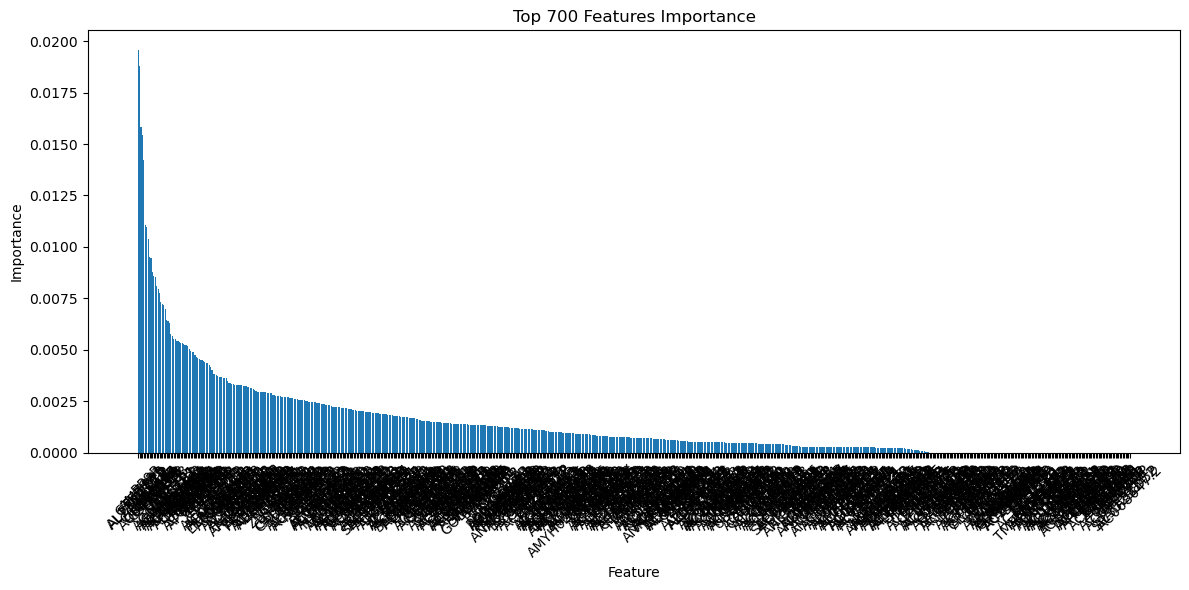

Last important feature:  558


In [11]:
df = pd.read_csv("../Datasets/Dataset14/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_names = X.columns

k_values = [700]

selected_features_dict = {}

for k in k_values:
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)
    feature_importances = clf.feature_importances_
    selected_features = np.array(feature_names)[
        np.argsort(feature_importances)[::-1][:k]]

    selected_features_dict[k] = selected_features

    sorted_idx = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title(f"Top {k} Features Importance")
    plt.bar(range(k), feature_importances[sorted_idx][:k], align="center")
    plt.xticks(range(k), np.array(feature_names)[sorted_idx][:k], rotation=45)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

    zero_importance_index = np.where(feature_importances == 0)[0]
    print("Last important feature: ", len(
        X.columns)-len(zero_importance_index))

### Feature Selection

In [12]:
df = pd.read_csv("../Datasets/Dataset14/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_counts = list(range(1, 144))

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

feature_importances = clf.feature_importances_

selected_features = X.columns[np.argsort(feature_importances)[::-1]]

datasets = {}
for count in feature_counts:
    datasets[count] = X[selected_features[:count]].copy()
    datasets[count]['Diagnosis'] = y

for count, dataset in datasets.items():
    dataset.to_csv(
        f'../Datasets/Dataset14/Feature_Select/dataset_{count}.csv', index=True)

## Model Building

### Check CV Score for Different Models

In [13]:
feature_counts = list(range(1, 144))

models = {
    "SVM(linear)": SVC(kernel='linear'),
    "SVM(poly)": SVC(kernel='poly'),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "ANN": MLPClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
}

results = pd.DataFrame(
    columns=["Model Name", "Feature Count", "CV Score (Mean +/- Std)"])

for count in tqdm(feature_counts, desc="Processing feature counts", unit=" feature counts", colour='green'):
    file_path = f"../Datasets/Dataset14/Feature_Select/dataset_{count}.csv"
    df = pd.read_csv(file_path, index_col=0)

    X = df.drop('Diagnosis', axis=1)
    y = df['Diagnosis']

    for model_name, model in models.items():
        cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        if model_name == "ANN":
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                scores = cross_val_score(model, X, y, cv=cv)
        elif model_name == "Logistic Regression": 
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                scores = cross_val_score(model, X, y, cv=cv)
        else:
            scores = cross_val_score(model, X, y, cv=cv)
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        result = f"{mean_score:.4f} +/- {std_score:.4f}"
        new_data = pd.DataFrame({"Model Name": [model_name],
                                 "Feature Count": [count],
                                 "CV Score (Mean +/- Std)": [result]})
        results = pd.concat([results, new_data], ignore_index=True)
        # print(f"{model_name} with {count} features: {result}")

results.sort_values(by=["CV Score (Mean +/- Std)"],
                    ascending=False, inplace=True)
results.to_csv("../Datasets/Dataset14/Feature_Select/results.csv", index=False)

Processing feature counts: 100%|██████████| 143/143 [05:02<00:00,  2.11s/ feature counts]


In [14]:
df = pd.read_csv("../Datasets/Dataset14/Feature_Select/results.csv")
df.head(10)

Model Name  Feature Count CV Score (Mean +/- Std)
0  Random Forest            126       0.7931 +/- 0.0436
1  Random Forest            129       0.7931 +/- 0.0378
2  Random Forest            103       0.7931 +/- 0.0308
3        XGBoost             23       0.7862 +/- 0.0669
4            ANN            114       0.7862 +/- 0.0258
5  Random Forest             14       0.7862 +/- 0.0258
6  Random Forest             24       0.7793 +/- 0.0640
7  Random Forest             26       0.7793 +/- 0.0560
8  Random Forest             19       0.7793 +/- 0.0468
9  Random Forest            140       0.7793 +/- 0.0352

### Check Distributions

In [17]:
feature_count = 126

data = pd.read_csv(
    f'../Datasets/Dataset14/Feature_Select/dataset_{feature_count}.csv')

target_column = data.columns[feature_count + 1]

num_rows = math.ceil(feature_count / 4)
num_columns = 4

fig, axes = plt.subplots(num_rows, num_columns, figsize=(80, 140))

for i in range(min(feature_count, num_rows * num_columns)):
    row_index = i // num_columns
    col_index = i % num_columns

    sns.histplot(
        data=data, x=data.columns[i + 1], hue=target_column, kde=True, ax=axes[row_index, col_index])

    axes[row_index, col_index].set_title(
        f'Distribution of {data.columns[i + 1]}')

    axes[row_index, col_index].set_xlabel(data.columns[i + 1])

    axes[row_index, col_index].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

### Check Accuracy

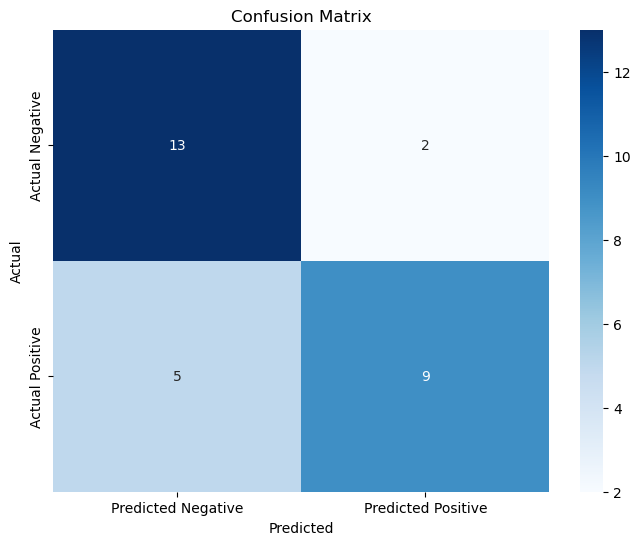

Accuracy: 0.76
Precision: 0.82
Recall (Sensitivity): 0.64
Specificity: 0.87
F1 Score: 0.72


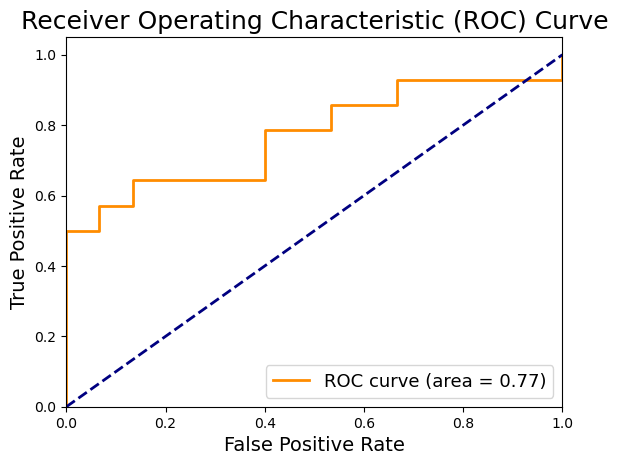

In [18]:
feature_count = 126

df = pd.read_csv(
    f'../Datasets/Dataset14/Feature_Select/dataset_{feature_count}.csv', index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

y_scores = clf.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1:.2f}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
plt.legend(loc='lower right', fontsize=13)
plt.show()